In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from tensorflow import keras
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

In [2]:
df = pd.read_csv('./Data/RainAccum_WL.csv')

In [3]:
df = df.rename(columns={'Unnamed: 0': 'Date_time'})

In [4]:
df.set_index(['Date_time'],inplace=True)

In [5]:
df.head()

,PRCP,LAT,LONG,HT
Date_time,,,,
2005-11-26 00:00:00,1411.0,-28.5031,153.3817,1.52
2005-11-26 00:15:00,1411.0,-28.5031,153.3817,1.53
2005-11-26 00:30:00,1411.0,-28.5031,153.3817,1.52
2005-11-26 00:45:00,1411.0,-28.5031,153.3817,1.53
2005-11-26 01:00:00,1411.0,-28.5031,153.3817,1.54


In [6]:
def show_corr_heatmap(df):
    # https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

    plt.figure(figsize=(20, 10))

    corr_matrix = df.corr()

    # mask to hide the upper triangle of the symmetric corr-matrix
    # mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

    heatmap = sns.heatmap(

        # correlation matrix
        corr_matrix,

        # mask the top triangle of the matrix
        # mask=mask,

        # two-contrast color, different color for + -
        cmap="PiYG",

        # color map range
        vmin=-1, vmax=1,

        # show corr values in the cells
        annot=True
    )

    # set a title
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=16);

    plt.show()

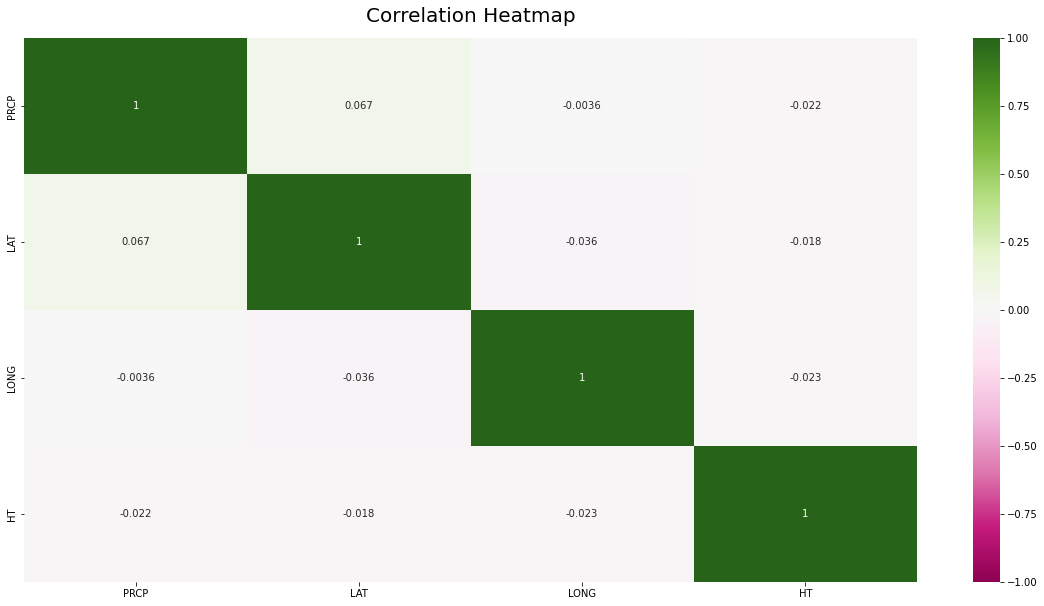

In [7]:
show_corr_heatmap(df)

In [13]:
def plot_to_buf(data, height=2800, width=2800, inc=0.3):
    xlims = (data[:,0].min(), data[:,0].max())
    ylims = (data[:,1].min(), data[:,1].max())
    dxl = xlims[1] - xlims[0]
    dyl = ylims[1] - ylims[0]

    print('xlims: (%f, %f)' % xlims)
    print('ylims: (%f, %f)' % ylims)

    buffer = np.zeros((height+1, width+1))
    for i, p in enumerate(data):
        print('\rloading: %03d' % (float(i)/data.shape[0]*100), end=' ')
        x0 = int(round(((p[0] - xlims[0]) / dxl) * width))
        y0 = int(round((1 - (p[1] - ylims[0]) / dyl) * height))
        buffer[y0, x0] += inc
        if buffer[y0, x0] > 1.0: buffer[y0, x0] = 1.0
    return xlims, ylims, buffer

data = df # data.shape = (310216, 2) <<< your data here
xlims, ylims, I = plot_to_buf(data, height=100, width=100, inc=0.3)
ax_extent = list(xlims)+list(ylims)
plt.imshow(I,
           vmin=0,
           vmax=1, 
           cmap=plt.get_cmap('hot'),
           interpolation='lanczos',
           aspect='auto',
           extent=ax_extent
           )
plt.grid(alpha=0.2)
plt.title('Latent space')
plt.colorbar()

InvalidIndexError: (slice(None, None, None), 0)

<AxesSubplot:xlabel='Date_time'>

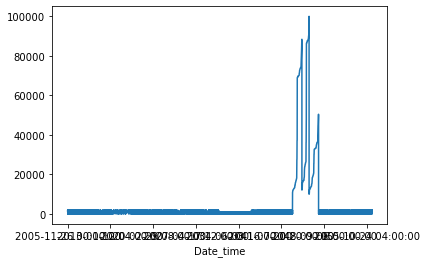

In [11]:
df['PRCP'].plot()

In [13]:
X = df.drop(['DayAvg', 'GMT','variable'], axis=1) #all columns except PRCP and RAIN, as both give the answer away.
y = df["DayAvg"]

In [14]:
random_state = 44
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

Epoch 1/10
3024/3024 [==============================] - 11s 2ms/step - loss: 120.2429 - val_loss: 62.9236
Epoch 2/10
3024/3024 [==============================] - 6s 2ms/step - loss: 62.0251 - val_loss: 61.5911
Epoch 3/10
3024/3024 [==============================] - 4s 1ms/step - loss: 60.9592 - val_loss: 61.0791
Epoch 4/10
3024/3024 [==============================] - 4s 1ms/step - loss: 60.1282 - val_loss: 59.9073
Epoch 5/10
3024/3024 [==============================] - 4s 1ms/step - loss: 59.2659 - val_loss: 59.3158
Epoch 6/10
3024/3024 [==============================] - 4s 1ms/step - loss: 58.7846 - val_loss: 59.6975
Epoch 7/10
3024/3024 [==============================] - 4s 1ms/step - loss: 58.4143 - val_loss: 59.5047
Epoch 8/10
3024/3024 [==============================] - 4s 1ms/step - loss: 58.1162 - val_loss: 58.6342
Epoch 9/10
3024/3024 [==============================] - 4s 1ms/step - loss: 57.8816 - val_loss: 58.5334
Epoch 10/10
3024/3024 [==============================] - 4s 1m

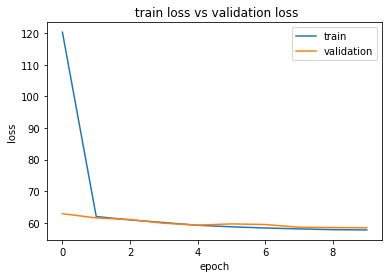

In [109]:
model = keras.Sequential()
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(1))
model.compile(optimizer='Adam', loss='mse')

# This builds the model for the first time:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [22]:
X.shape

(120945, 5)

In [28]:
X = X.reshape(1,1,1)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [15]:
model = keras.Sequential()
model.add(keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(1))
model.compile(optimizer='Adam', loss='mse')

# This builds the model for the first time:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

IndexError: tuple index out of range